# Bonus point
***

Now we will compute the *cosine similarity* between the title embeddings of the papers, to see wich titles appear to be similar. To do so we upload the title embeddings previously computed in the other notebook and start from there


In [1]:
import json
from scipy import spatial
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy  as np 
import time
import matplotlib.pyplot as plt
from dask.distributed import Client, LocalCluster

import dask.bag as db
import json


from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import geopandas
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from nltk.corpus import stopwords


We setup a local cluster to aid with the reading of the files.

In [2]:
cluster = LocalCluster(n_workers=4,threads_per_worker=2) 
client  = Client(cluster)
#client = Client('localhost:8786')
client

Client Scheduler: tcp://127.0.0.1:49856 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 8.43 GB


### Title embeddings

The title embeddings have been previously computed and are here re-uploaded in the notebook, it's a dictionary containing the paper id and the title embeding

In [3]:
t_emb = json.load(open('title_embeddings.json'))


### Computaion of the cosine similarity
Since the computation for the cosine similarity involves doing a scalar product between vectors, the title embeddings need to be of the same length to perform the operation. Even if this is not ideal, we choose to take the mean of each group of vectors associated to each title and perform the cosine similarity on this quantity. This approach does not consider the relations between words in the phrase but should still find the most similar titles in the dataset.

In [4]:
mean_emb_list = [np.mean(title['title_embedding'],axis = 0) for title in t_emb ]

Here we compute the actual cosine similarity between all of the different titles  with the module `spatial` of scipy.

To actually obtain the cosine similarity from the `spatial.distance.cosine` function we need to subract it's output from 1  

In [5]:
N = len(t_emb)
similarities = np.zeros([N,N])
for i in range(N):
    for j in range(N):
        similarities[i,j] = 1 - spatial.distance.cosine(mean_emb_list[i], mean_emb_list[j])



Here is the relation between all of the papers in the dataset. some papers, maybe containing words not in the english language or weird characters have a low cosine similarity with basically all of the dataset.

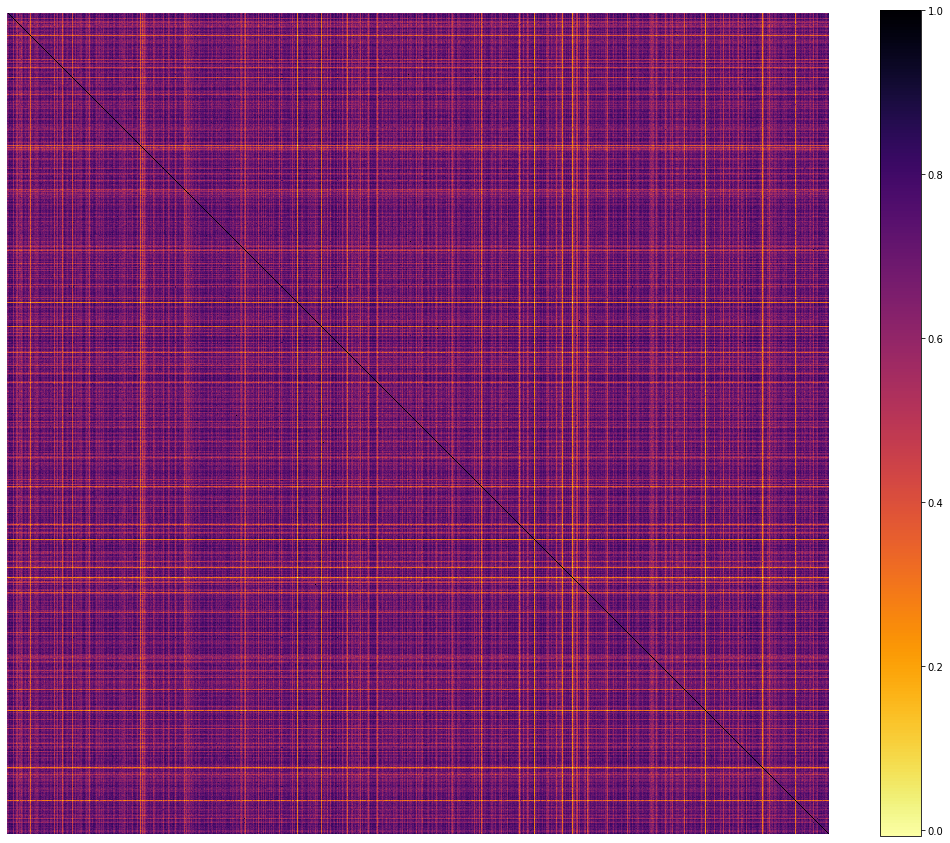

In [15]:
%matplotlib inline
#sns.heatmap(similarities,cmap='inferno_r',cbar=False)
fig, ax = plt.subplots(figsize=[15,15])
im = ax.imshow(similarities,cmap='inferno_r')
fig.colorbar(im,shrink=0.78)
fig.tight_layout()


plt.axis('off')
plt.show()

The code below is aimed at sorting each possible pair of papers to see wich ones are the most similar. 

Then the actual titles are retrieved from the original files, since we know the paper ID.

In [16]:
np.fill_diagonal(similarities,0)
similarities *= np.tri(*similarities.shape)

In [17]:
ind = np.unravel_index(np.argsort(-similarities, axis=None), similarities.shape)

In [18]:
with open('dummy.mapd') as file:
    flist = ['json1line_COVID_papers/'+i.strip() for i in file]
with open('dummy.mapd') as file:
    flistgit = ['https://raw.githubusercontent.com/Luca-Negri/Meta_Analysis_of_COVID_papers/main/json1line_COVID_papers/'+i.strip() for i in file]



b = db.read_text(flist).map(json.loads).repartition(8)

In [19]:
total_tiles = b.pluck('metadata').pluck('title').compute()
total_ids =   b.pluck('paper_id').compute() 

Here are the 20 most similar papers 

In [20]:
N = 20
titles = []
paper_ids = 0
for i in range(N):
    print('\n\nTitle 1:\n  ',total_tiles[total_ids.index(t_emb[ind[0][i]]['paper_id'])])
    print('Title 2:\n  ',total_tiles[total_ids.index(t_emb[ind[1][i]]['paper_id'])])
    print('\nCosine similarity :: ', similarities[ind[0][i],ind[1][i]])




Title 1:
   Russian Text © The Author(s), 2021
Title 2:
   Russian Text © The Author(s), 2021

Cosine similarity ::  1.0


Title 1:
   COmment
Title 2:
   Comment

Cosine similarity ::  1.0


Title 1:
   Quantification of occupational and community risk factors for SARS-CoV-2 seropositivity among healthcare workers in a large U.S. healthcare system
Title 2:
   Quantification of occupational and community risk factors for SARS-CoV-2 seropositivity among healthcare workers in a large U.S. healthcare system

Cosine similarity ::  1.0


Title 1:
   ICMJE Form for Disclosure of Potential Conflicts of Interest
Title 2:
   ICMJE Form for Disclosure of Potential Conflicts of Interest

Cosine similarity ::  1.0


Title 1:
   To appear in: Public Health in Practice
Title 2:
   To appear in: Public Health

Cosine similarity ::  0.977841089737125


Title 1:
   A C A D E M I C P R A C T I C E I N E C O L O G Y A N D E V O L U T I O N Thanks for inviting me to the party: Virtual poster sessions as

We can see that some papers have an exact same title, so the cosine similarity is 1.0 . The chart is also dominated by weird titles containing lots of single letter words and this gives the algorithm a hard time figuring out wich titles are actually similar. other than these weird outliers the other titles are actually pretty similar in content, so we can say that the algorithm is working as intended.

In [35]:
paper_ind = 100
indsmask = ind[0]==paper_ind 

ind2 = ind[1][indsmask]

N = 10
titles = []
paper_ids = 0
for i in range(N):
    print('\n\nTitle 1:\n  ',total_tiles[total_ids.index(t_emb[paper_ind]['paper_id'])])
    print('Title 2:\n  ',total_tiles[total_ids.index(t_emb[ind2[i]]['paper_id'])])
    print('\nCosine similarity :: ', similarities[paper_ind,ind2[i]])



Title 1:
   COVID-19 in Critically Ill Patients in North Brabant, the Netherlands: Patient Characteristics and Outcomes
Title 2:
   Risk factors for severity on admission and the disease progression during hospitalization in a large cohort of COVID-19 patients in Japan

Cosine similarity ::  0.8380290781936583


Title 1:
   COVID-19 in Critically Ill Patients in North Brabant, the Netherlands: Patient Characteristics and Outcomes
Title 2:
   Digital teaching as an instrument for cross-location teaching networks in medical informatics: opportunities and challenges courses must be developed at educational institutions. In view of the

Cosine similarity ::  0.8110915842861758


Title 1:
   COVID-19 in Critically Ill Patients in North Brabant, the Netherlands: Patient Characteristics and Outcomes
Title 2:
   Full Title: A systematic review of MERS-CoV (Middle East Respiratory Syndrome Coronavirus) 2 seroprevalence and viral RNA prevalence in dromedary camels: implications for animal vacc

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2b33b939-6077-4cfb-95d6-a9ab8510ea0b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>